In [1]:
from bggcomplex import *
import numpy as np

In [2]:
BGG = BGGComplex("A4")

In [3]:
BGG.compute_signs()

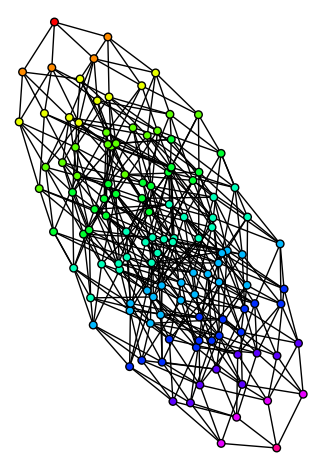

In [4]:
BGG.plot_graph().plot()

In [5]:
BGG.compute_maps(BGG.zero_root);